In [1]:
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
def replace_price_ticks(ax, xaxis, label):
    ticks = np.arange(0, 9e5, 1e5)
    labels = [str(int(round(t/1e3,0))) for t in ticks]
    if xaxis:
        ax.set_xticks(ticks, labels)
        ax.set_xlabel(f'{label} / 10$^3\\times$USD')
    else:
        ax.set_yticks(ticks, labels)
        ax.set_ylabel(f'{label} / 10$^3\\times$USD')

def convert_strings(num, base):
    length = int(np.floor(np.log10(num)))
    if length < base:
        s = '0'+str(round(num, -(base-2)))[:2]
    elif length == base:
        s = str(round(num, -(base-2)))[:3]
    else:
        raise ValueError('The length of the number to round is larger')
    return '{}.{}E+{:02d}'.format(s[0], s[1:], base)

error_text = '''\
- Average sale price: {}
- Mean absolute error: {}
- Median absolute error: {}
- Root mean squared error: {}
- R Squared: {:.4f}\
'''

In [3]:
dtypes = dict(MSSubClass=str)
data_df = pd.read_csv(os.path.join('data', 'ames-data-no-missing.csv'), index_col=0)

In [4]:
np.where(data_df.isnull().any())

(array([], dtype=int64),)

In [5]:
columns = pd.read_csv(os.path.join('data', 'columns-small.txt'),
                      index_col=False, header=None).values.flatten()

In [25]:
# corr_df = data_df.corr()['SalePrice'].sort_values(key=abs, ascending=False).head(5)
# corr_names = np.unique(list(map(lambda x: x.split('_')[0], corr_df.index)))
# list(filter(lambda x: '_' in x, corr_df.index))
corr_names = columns
corr_cols = list(filter(lambda x: x.split('_')[0] in corr_names, data_df.columns))
# pd.DataFrame.from_dict({'found': list(map(lambda x: x in df.columns, corr_names)), 'cols': df.columns})
df = data_df[corr_cols].copy()

## Number of unique columns in the subset

In [26]:
np.unique(corr_names).shape[0]

27

## Check for duplicated columns in the subset of data

In [13]:
df.loc[df.duplicated()]

,OverallQual,OverallCond,YearBuilt,GrLivArea,GarageCars,YrSold,SalePrice,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,...,Garage,Deck,Porch_Open,Porch_Enclosed,Porch_3Ssn,Porch_Screen,Pool,Bsmt,TotalFullBath,TotalHalfBath
Id,,,,,,,,,,,,,,,,,,,,,


In [95]:
tmp = df.drop('SalePrice', axis=1)
df.loc[tmp.duplicated(keep=False)].sort_values(by=['OverallQual', 'OverallCond', 'YearBuilt', 'GrLivArea', 'YrSold'])

,OverallQual,OverallCond,YearBuilt,GrLivArea,GarageCars,YrSold,SalePrice,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,...,Garage,Deck,Porch_Open,Porch_Enclosed,Porch_3Ssn,Porch_Screen,Pool,Bsmt,TotalFullBath,TotalHalfBath
Id,,,,,,,,,,,,,,,,,,,,,
594,6,5,2003,848,2,2009,140000,False,False,False,...,True,True,False,False,False,False,False,True,2,0
1369,6,5,2003,848,2,2009,144000,False,False,False,...,True,True,False,False,False,False,False,True,2,0
204,6,5,2004,848,2,2008,149000,False,False,False,...,True,True,False,False,False,False,False,True,2,0
691,6,5,2004,848,2,2008,141000,False,False,False,...,True,True,False,False,False,False,False,True,2,0
1442,6,5,2004,848,2,2008,149300,False,False,False,...,True,True,False,False,False,False,False,True,2,0
194,7,5,2004,1709,2,2006,130000,False,False,False,...,True,False,True,False,False,False,False,True,2,0
1089,7,5,2004,1709,2,2006,137500,False,False,False,...,True,False,True,False,False,False,False,True,2,0
512,7,5,2005,1368,2,2006,202665,False,False,False,...,True,True,True,False,False,False,False,True,2,0
1307,7,5,2005,1368,2,2006,202500,False,False,False,...,True,True,True,False,False,False,False,True,2,0


In [14]:
X = df.drop('SalePrice', axis=1)
y = df['SalePrice']

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15,
                                                    random_state=42)

In [58]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [59]:
model = LassoCV(n_alphas=1000, eps=0.001, max_iter=10000)

In [60]:
model.fit(X_train_scaled, y_train)

LassoCV(max_iter=10000, n_alphas=1000)

In [61]:
model.alpha_

183.8622191561116

In [62]:
test_predictions = model.predict(X_test_scaled)
MAE = metrics.mean_absolute_error(y_test, test_predictions)
MSE = metrics.mean_squared_error(y_test, test_predictions)
RMSE = np.sqrt(MSE)
r2 = metrics.r2_score(y_test, test_predictions)
MedAE = metrics.median_absolute_error(y_test, test_predictions)
MAPerE = metrics.mean_absolute_percentage_error(y_test, test_predictions)

In [63]:
base = int(np.floor(np.log10(y_test.mean())))
str_vals = [convert_strings(y_test.mean(), base),
            convert_strings(MAE, base),
            convert_strings(MedAE, base),
            convert_strings(RMSE, base),
            r2]

Text(0.5, 1.0, 'Lasso Regression')

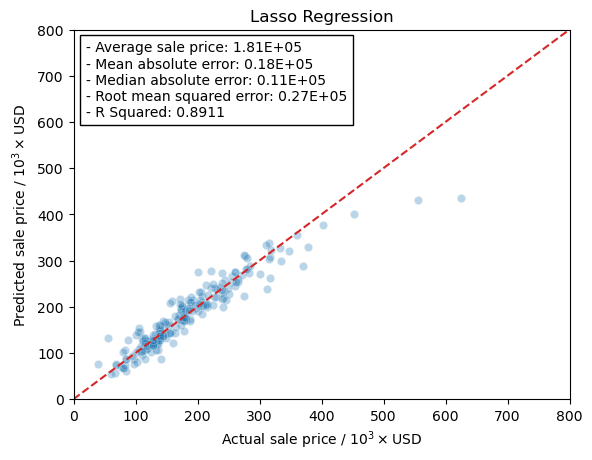

In [64]:
fig, ax = plt.subplots()
sns.scatterplot(x=y_test, y=test_predictions, alpha=0.3, ax=ax)
replace_price_ticks(ax, True, 'Actual sale price')
replace_price_ticks(ax, False, 'Predicted sale price')
ylim = ax.get_ylim()
xlim = ax.get_xlim()
new_lim = list(ylim)
if new_lim[0] > xlim[0]:
    new_lim[0] = xlim[0]
if new_lim[1] < xlim[1]:
    new_lim[1] = xlim[1]
ax.set_ylim(new_lim)
ax.set_xlim(new_lim)
ax.plot(new_lim, new_lim, color='tab:red', linestyle='--')
ax.text(s=error_text.format(*str_vals),
        x=0.025, y=0.97, transform=ax.transAxes, ha='left', va='top',
        bbox=dict(fc="none"))
ax.set_title('Lasso Regression')

In [99]:
residuals = y_test - test_predictions
percent = residuals / y_test * 100

Text(0.5, 0, 'Percent')

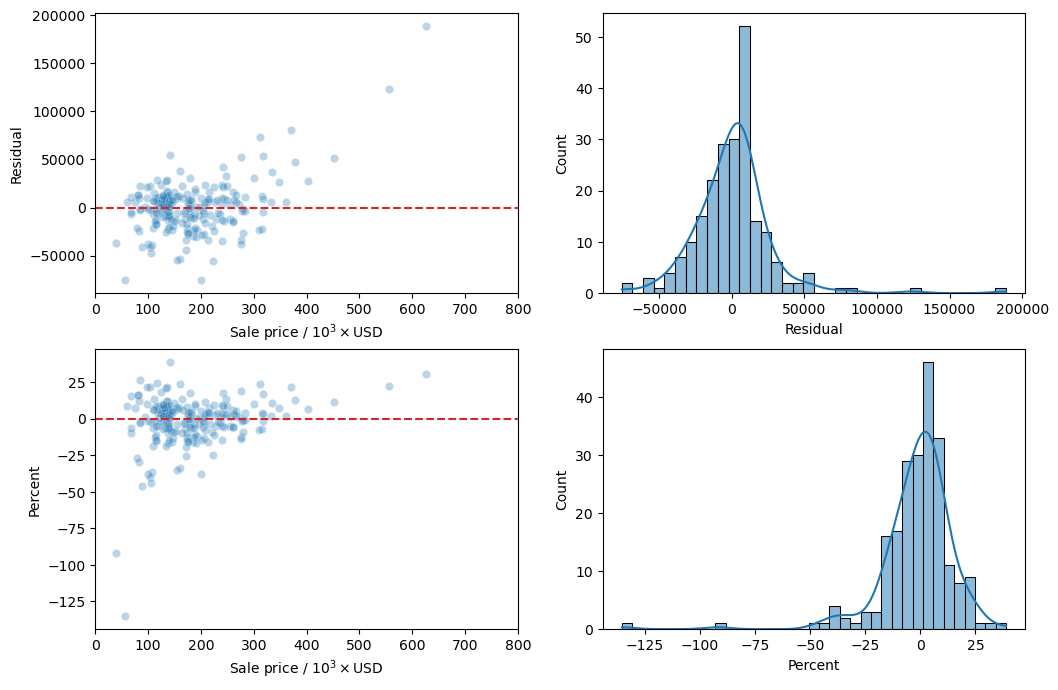

In [103]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
ax = np.ndarray.flatten(ax)
sns.scatterplot(y=residuals, x=y_test, ax=ax[0], alpha=0.3)
ax[0].set_ylabel('Residual')
replace_price_ticks(ax[0], True, 'Sale price')
ax[0].axhline(0, color='tab:red', linestyle='--')
sns.histplot(x=residuals, kde=True, ax=ax[1])
ax[1].set_xlabel('Residual')
sns.scatterplot(y=percent, x=y_test, ax=ax[2], alpha=0.3)
ax[2].set_ylabel('Percent')
replace_price_ticks(ax[2], True, 'Sale price')
ax[2].axhline(0, color='tab:red', linestyle='--')
sns.histplot(x=percent, kde=True, ax=ax[3])
ax[3].set_xlabel('Percent')

In [86]:
from joblib import dump, load

In [87]:
final_scaler = StandardScaler()

In [88]:
final_model = Lasso(alpha=183.8622191561116)

In [89]:
final_model.fit(final_scaler.fit_transform(X), y)

Lasso(alpha=183.8622191561116)

In [90]:
dump(final_model, os.path.join('data', 'sales-model-small.joblib'))

['data\\sales-model-small.joblib']

In [91]:
dump(final_scaler, os.path.join('data', 'sales-scaler-small.joblib'))

['data\\sales-scaler-small.joblib']

In [106]:
with open(os.path.join('data', 'column-order-small.txt'), 'w') as fn:
    fn.write(','.join(df.columns))